TODO
* normalize so vector is between 0 and 1, not only 1
* use more vectors in tsne
* find classes thru recipe cluster
* add names of recipes when hovero ver point in tsne

In [2]:
import pandas as pd
import numpy as np
import ast
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import normalize

In [42]:
#HELPERS
def filter_recipes(recipes, ingredients_set):
    """
    removes recipe if ingredients in recipe is not in our ingredients list
    """
    filtered_recipes = []
    recipes_ids = []
    for i, recipe in enumerate(recipes):
        found = True
        for word in recipe:
            if word not in ingredients_set:
                found = False
                break
        if found and len(recipe) > 0:
            filtered_recipes.append(recipe)
            recipes_ids.append(i)
    return filtered_recipes, recipes_ids

def embed_recipe(recipe, model):
    recipe_embedding = np.empty([len(recipe), model.vector_size])
    for i, ingredient in enumerate(recipe):
        recipe_embedding[i] = model.wv[ingredient]
    
    return normalize(recipe_embedding)

def add_recipe_embedding(recipe_embedding, model):
    resultant = np.zeros(model.vector_size)
    for ingr_embd in recipe_embedding:
        resultant += ingr_embd
    return resultant

In [50]:
#READ DATA
recipes_path = 'data/RAW_recipes.csv'
recipes = pd.read_csv(recipes_path)
recipes_df = recipes['ingredients']
recipes_df = recipes_df.apply(ast.literal_eval)
recipes = list(recipes_df)

In [44]:
min_count = 1000
model = Word2Vec(min_count=min_count,
                     window=3,
                     size=50,
                     sg=0
                    )
model.build_vocab(recipes, progress_per=100)
vocab = list(model.wv.vocab)
vocab_set = set(vocab)

#Find new recipes which only has ingredients present in vocab
filtered_recipes, recipes_ids = filter_recipes(recipes, vocab_set)

print(len(recipes_ids))

model.train(filtered_recipes, total_examples=model.corpus_count, epochs=30, report_delay=1)

18491


(2305320, 4081560)

In [38]:
print(len(filtered_recipes), len(vocab))
print(dir(model.wv))
dict(model.wv.__dict__)

18491 316
['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adapt_by_suffix', '_load_specials', '_log_evaluate_word_analogies', '_save_specials', '_smart_save', 'accuracy', 'add', 'closer_than', 'cosine_similarities', 'distance', 'distances', 'doesnt_match', 'evaluate_word_analogies', 'evaluate_word_pairs', 'get_keras_embedding', 'get_vector', 'index2entity', 'index2word', 'init_sims', 'load', 'load_word2vec_format', 'log_accuracy', 'log_evaluate_word_pairs', 'most_similar', 'most_similar_cosmul', 'most_similar_to_given', 'n_similarity', 'rank', 'relative_cosine_similarity', 'save', 'save_word2vec_format', 'similar_by_vector', 'similar_by_word', 'si

{'vectors': array([[ 0.14170216, -0.774336  ,  0.87870204, ...,  0.9999742 ,
          0.10175785,  0.410551  ],
        [-0.05989535, -2.3582766 , -1.1789919 , ...,  0.01509447,
         -0.33113462, -0.18033886],
        [-2.012214  , -0.85301316,  1.1141021 , ...,  1.034911  ,
         -0.3618323 , -0.4920873 ],
        ...,
        [ 0.9060749 ,  0.17588542, -0.10081895, ..., -0.2737566 ,
          0.3848246 ,  0.19888157],
        [ 0.5523016 ,  1.6296211 ,  0.36084342, ..., -1.1839123 ,
         -1.3082868 , -1.161622  ],
        [ 0.35631567,  0.8870825 ,  0.388689  , ..., -0.6889352 ,
         -0.7302108 , -0.5009465 ]], dtype=float32),
 'vocab': {'honey': <gensim.models.keyedvectors.Vocab at 0x1a3bd57f50>,
  'butter': <gensim.models.keyedvectors.Vocab at 0x1a3bd57fd0>,
  'olive oil': <gensim.models.keyedvectors.Vocab at 0x1a3e6de510>,
  'salt': <gensim.models.keyedvectors.Vocab at 0x1a3e6dee50>,
  'eggs': <gensim.models.keyedvectors.Vocab at 0x1a2168c8d0>,
  'milk': <gensim.mo

In [20]:
#embed all ingredients in each recipe
recipe_embeddings = list(map(lambda x: embed_recipe(x, model), tqdm(filtered_recipes)))

#add all ingredients eembedding in each recipe
added_recipe_embeddings = list(map(lambda x : add_recipe_embedding(x, model), tqdm(recipe_embeddings)))
added_recipe_embeddings = np.array(added_recipe_embeddings)

100%|██████████| 18491/18491 [00:00<00:00, 50093.32it/s]


In [28]:
len(added_recipe_embeddings)

18491

In [54]:
#TSNE on recipe embeddings
X = added_recipe_embeddings
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)



In [55]:
list(recipes_df[recipes_ids])
X.shape

(18491, 2)

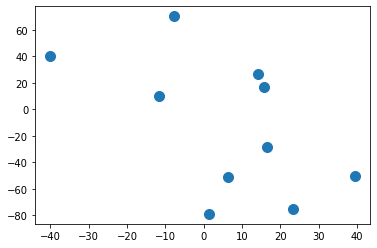

In [64]:
x = X[:,0][:10]
y = X[:,1][:10]
names = recipes_df[recipes_ids]
names = np.array(list("ABCDEFGHIJ"))
c = np.random.randint(1,5,size=15)

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x,y, s=100, cmap=cmap, norm=norm)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    print(text)
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

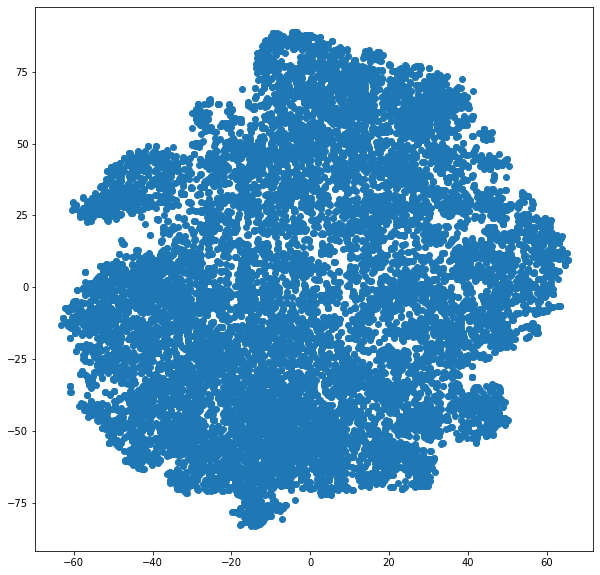

In [23]:
df = pd.DataFrame(X, columns=['x', 'y'])
df.head()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(df['x'], df['y'])

#plt.savefig('recipe_embedding_tsne.png')